In [ ]:
# %pip install numpy
# %pip install scikit-learn
# %pip install pillow
# %pip install kagglehub
# %pip install monai
# %pip install matplotlib
# %pip install torch
# %pip install pylatexenc
# %pip install ipywidgets
# %pip install opencv-python
# %pip install piqture
# %pip install qiskit_machine_learninga
# %pip install tensorflow


In [ ]:
import os
from IPython.display import clear_output

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from monai.transforms import ScaleIntensity
import kagglehub
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from piqture.neural_networks.layers.convolutional_layer import QuantumConvolutionalLayer
from piqture.neural_networks.layers.pooling_layer import QuantumPoolingLayer2
from qiskit.circuit import QuantumCircuit
from qiskit_algorithms.optimizers import SPSA
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit.circuit.library import ZFeatureMap
import torch
from PIL import Image

#### Download latest version https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [2]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
# print("Path to dataset files:", path)

#### Define dataset paths
##### !!! Remove .DS_Store from folders

In [ ]:
# !rm -rf {path}/chest_xray/chest_xray/train/NORMAL/.DS_Store
# !rm -rf {path}/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store
# !rm -rf {path}/chest_xray/chest_xray/test/NORMAL/.DS_Store
# !rm -rf {path}/chest_xray/chest_xray/test/PNEUMONIA/.DS_Store

In [3]:
dataset_path = f'{path}/chest_xray/chest_xray/train/'
validation_path_norm = f'{path}/chest_xray/chest_xray/test/NORMAL'
validation_path_pneu = f'{path}/chest_xray/chest_xray/test/PNEUMONIA'

#### Check data

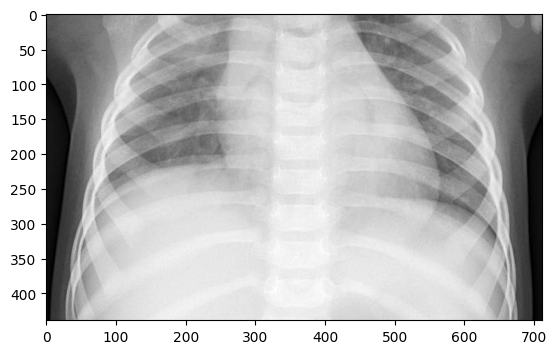

In [4]:
xray_image = cv2.imread(f'{dataset_path}/PNEUMONIA/person1_bacteria_1.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(xray_image, cmap='gray')

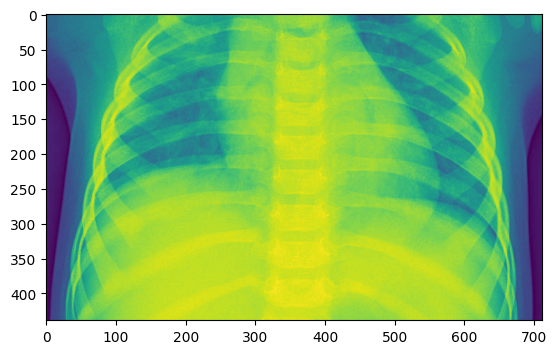

In [5]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
xray_image_scaled = transform_img(xray_image)
colored_xray = cm.viridis(xray_image_scaled)
plt.imshow(colored_xray)

#### Set the image size, categories

In [6]:
img_size = (128, 128)

categories = ['NORMAL', 'PNEUMONIA']

data = []
labels = []

for label, category in enumerate(categories):
    folder_path = os.path.join(dataset_path, category)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize(img_size)
            img_array = img_to_array(img) / 255.0
            data.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")

In [7]:
data = np.array(data)
labels = np.array(labels)

#### Data augmentation and transformations

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [9]:
X_train_res = X_train.reshape(-1, 8)
X_test_res = X_test.reshape(-1, 8)

In [10]:
X_train_min = X_train_res[:1000]
y_train_min = y_train[:1000]
X_test_min = X_test_res[:200]
y_test_min = y_test[:200]

In [11]:
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train_min)

X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_min, dtype=torch.float32)

In [12]:
X_test_pca = pca.transform(X_test_min)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_min, dtype=torch.float32)

#### Create & Visualize the QNN

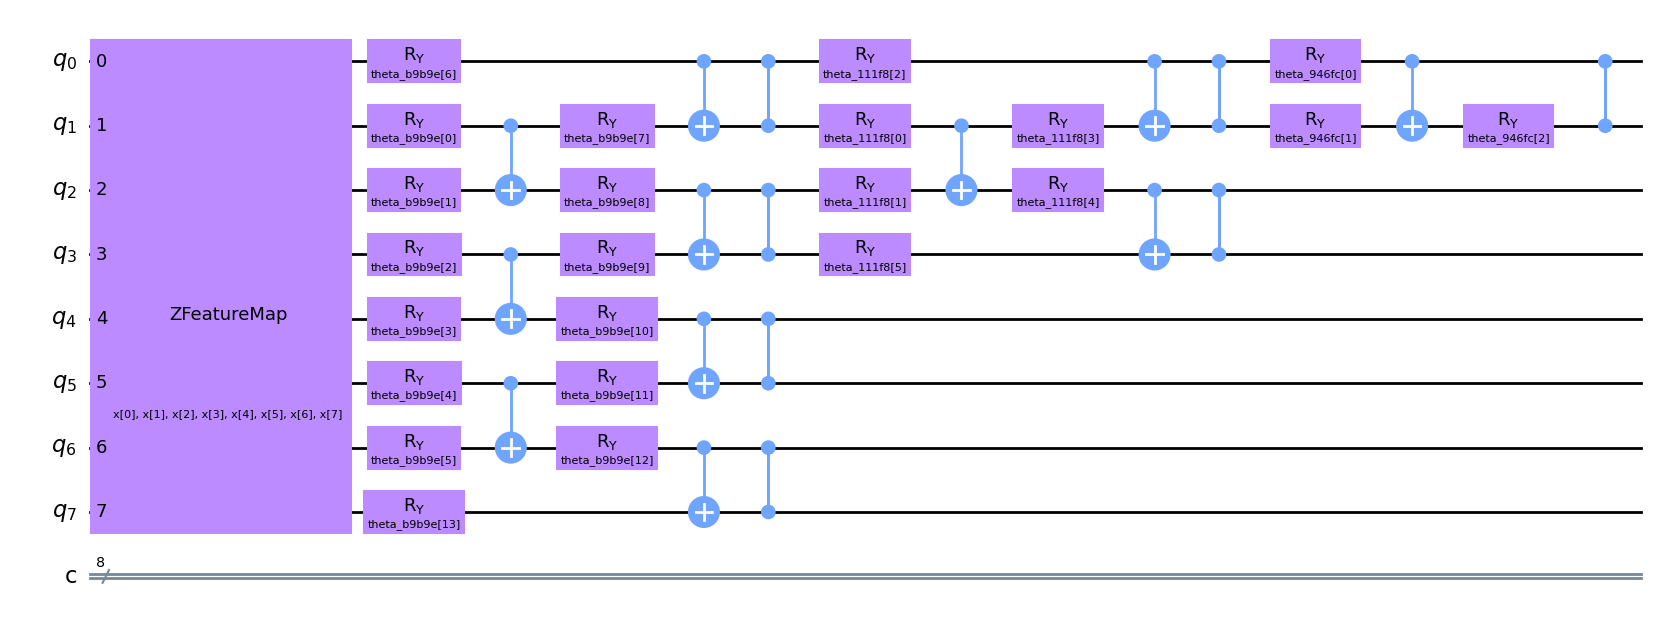

In [13]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

conv_layer1, _ = QuantumConvolutionalLayer(num_qubits=8).build_layer()
ansatz.compose(conv_layer1, list(range(8)), inplace=True)

pool_layer1, _ = QuantumPoolingLayer2(num_qubits=8, circuit=QuantumCircuit(8), unmeasured_bits=list(range(8))).build_layer()
ansatz.compose(pool_layer1, list(range(8)), inplace=True)

conv_layer2, _ = QuantumConvolutionalLayer(num_qubits=4).build_layer()
ansatz.compose(conv_layer2, list(range(4)), inplace=True)

pool_layer2, _ = QuantumPoolingLayer2(num_qubits=4, circuit=QuantumCircuit(4), unmeasured_bits=list(range(4))).build_layer()
ansatz.compose(pool_layer2, list(range(4)), inplace=True)

conv_layer3, _ = QuantumConvolutionalLayer(num_qubits=2).build_layer()
ansatz.compose(conv_layer3, list(range(2)), inplace=True)

pool_layer3, _ = QuantumPoolingLayer2(num_qubits=2, circuit=QuantumCircuit(2), unmeasured_bits=list(range(2))).build_layer()
ansatz.compose(pool_layer3, list(range(2)), inplace=True)

circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

circuit.draw("mpl", style="clifford")


#### Objective function visualization

In [14]:
objective_func_vals = []

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

#### Train with SPSA optimizer

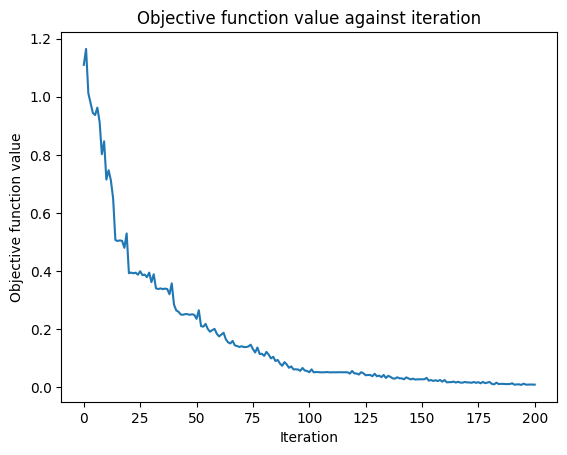

In [ ]:
classifier = NeuralNetworkClassifier(
    neural_network=qnn,
    optimizer=SPSA(maxiter=100, learning_rate=0.02, perturbation=0.01),
    loss='cross_entropy',
    callback=callback_graph
)

classifier.fit(X_train_tensor, y_train_tensor)

In [16]:
train_accuracy = np.round(100 * classifier.score(X_train_tensor, y_train_tensor), 2)
print(f"Accuracy from the training data: {train_accuracy}%")
print("***************************************************")
test_accuracy = np.round(100 * classifier.score(X_test_tensor, y_test_tensor), 2)
print(f"Accuracy from the test data: {test_accuracy}%")
predictions = classifier.predict(X_test_tensor)
print("***************************************************")
accuracy = np.mean(predictions == y_test_tensor.numpy())
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy from the training data: 74.4%
***************************************************
Accuracy from the test data: 68.0%
***************************************************
Accuracy: 68.00%


In [3]:
import utils.tutorial_magics

%qiskit_version_table
%qiskit_copyright